In [1]:
import numpy as np
import tensorflow as tf
import os
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from PIL import Image
import PIL
import io
import cv2
import matplotlib.pyplot as plt
import shutil

In [2]:
images_dir = 'C:/Prajesh/personal/ML_learning/my_work/image_segmentation/dataset/oxford-iiit-pet/images/'
maps_dir = 'C:/Prajesh/personal/ML_learning/my_work/image_segmentation/dataset/oxford-iiit-pet/annotations/trimaps/'
new_maps_dir = 'C:/Prajesh/personal/ML_learning/my_work/image_segmentation/dataset/oxford-iiit-pet/new_annotations/'

In [3]:
# for j in os.listdir(maps_dir):
#     if '._' not in j:
#         shutil.move(maps_dir + j, new_maps_dir + j)

In [4]:
# annot_list = []
# for j in os.listdir(new_maps_dir):
#     annot_list.append(j[:-4])
# img_list = []
# for j in os.listdir(images_dir):
#     img_list.append(j[:-4])

# # for i in img_list:
# #     if i not in annot_list:
# #         print(i)
# # count = 0
# # for i in os.listdir(images_dir):
# #     if '.mat' in i:
# #         count += 1
# #         print(i)
# # print(count)

In [5]:
# len(img_list)

In [6]:
# len(annot_list)

In [7]:
class DataGenerator(tf.keras.utils.Sequence):
    
    def __init__(self, images, maps, batch_size, INPUT_DIM, shuffle = False):
        
        self.images = images
        self.maps = maps
        self.batch_size = batch_size
        self.train_image_list = os.listdir(images)
#         self.train_image_list = [file for file in os.listdir(images) if file.endswith('.jpg')]
        self.INPUT_DIM = INPUT_DIM
        
    def __len__(self):
        return int(np.floor(len(self.train_image_list)/self.batch_size))
#         print(len(self.train_image_list) // self.batch_size)
#         return len(self.train_image_list) // self.batch_size
    
    def __getitem__(self, idx):
        X, y = self.__data_generation(idx)
        y -= 1
        
        return X, y #, w
    
    def __data_generation(self, idx):
        X = []
        y = []
        # w = []
        
        for j in range(idx * self.batch_size, (idx+1) * self.batch_size):
            img_arr = (img_to_array(load_img(self.images + os.listdir(self.images)[j], target_size = (self.INPUT_DIM, self.INPUT_DIM))))
            maps_arr = (img_to_array(load_img(
                self.maps + os.listdir(self.images)[j][:-4] + '.png',
                color_mode = 'grayscale', 
                target_size = (self.INPUT_DIM//2, self.INPUT_DIM//2)
            )))
            # class_weights = tf.constant([2.0, 1.0, 2.0])
            # class_weights = class_weights/tf.reduce_sum(class_weights)
            
            X.append(img_arr)
            y.append(maps_arr)
            # sample_weights = tf.gather(class_weights, indices=tf.cast(maps_arr, tf.int32))
            # w.append(sample_weights)
            
            # X.append(tf.image.adjust_saturation(img_arr, 0.5,))
            # y.append(maps_arr)
            # # sample_weights = tf.gather(class_weights, indices=tf.cast(maps_arr, tf.int32))
            # # w.append(sample_weights)
            
            # X.append(tf.image.flip_up_down(img_arr))
            # y.append(tf.reverse(maps_arr, [0]))
            # # sample_weights = tf.gather(class_weights, indices=tf.cast(tf.reverse(maps_arr, [0]), tf.int32))
            # # w.append(sample_weights)


        return tf.convert_to_tensor(X), tf.convert_to_tensor(y) #, tf.convert_to_tensor(w)

In [8]:
LR=1e-3
BATCH_SIZE=4
EPOCH=100
INPUT_DIM = 224
NUM_FILTERS = 128

data_gen = DataGenerator(images_dir, new_maps_dir, BATCH_SIZE, INPUT_DIM, shuffle = True)

In [9]:
x, y = data_gen.__getitem__(0)

In [10]:
x.shape

TensorShape([4, 224, 224, 3])

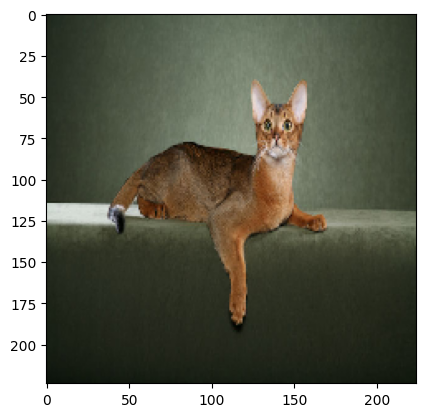

In [11]:
plt.imshow(x[0]/255)

In [12]:
y.shape

TensorShape([4, 112, 112, 1])

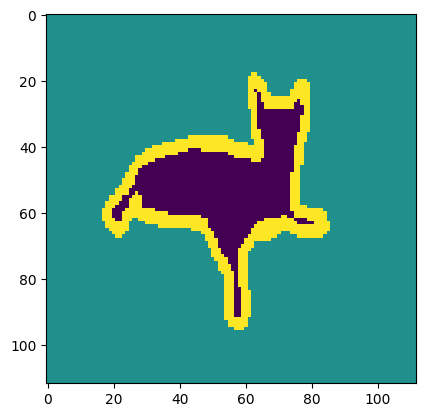

In [13]:
plt.imshow(y[0])

In [14]:
# w.shape

In [15]:
# plt.imshow(w[11])

In [16]:
def baseModel():
    basemodel = tf.keras.applications.ResNet50(
        weights = 'imagenet',
        include_top = False,
        input_shape = (INPUT_DIM, INPUT_DIM, 3)
    )
    
    basemodel.trainable = False
    
    conv1_relu,conv2_block3_out,conv3_block4_out,conv4_block6_out,conv5_block3_out=[basemodel.get_layer(layer_name).output for layer_name in ["conv1_relu","conv2_block3_out","conv3_block4_out","conv4_block6_out","conv5_block3_out"]]
    
    return tf.keras.Model(
        inputs=[basemodel.inputs],outputs=[conv1_relu,conv2_block3_out,conv3_block4_out,conv4_block6_out,conv5_block3_out]
    )

# baseModel().summary()

In [17]:
from tensorflow.keras.layers import Rescaling, Conv2DTranspose, BatchNormalization, Conv2D, Dropout

In [18]:
class Upsample(tf.keras.layers.Layer):
    def __init__(self,NUM_FILTERS):
        super(Upsample,self).__init__()
        self.conv_t_1=Conv2DTranspose(NUM_FILTERS,1,strides=2,activation='relu')
        self.norm_1=BatchNormalization()
    def call(self,x):
        x=self.norm_1(self.conv_t_1(x))
        return x

In [19]:
class ConvLayers(tf.keras.layers.Layer):
    def __init__(self,NUM_FILTERS):
        super(ConvLayers,self).__init__()
        self.conv_1=Conv2D(NUM_FILTERS*2,3,padding='same',activation='relu')
        self.norm_1=BatchNormalization()
        
        self.conv_2=Conv2D(NUM_FILTERS*4,3,padding='same',activation='relu')
        self.norm_2=BatchNormalization()
    def call(self,x):
        x=self.norm_1(self.conv_1(x))
        x=self.norm_2(self.conv_2(x))
        return x

In [20]:
inputs = tf.keras.layers.Input(shape = (INPUT_DIM, INPUT_DIM, 3))

x = Rescaling(1/255.0)(inputs)
x_112, x_56, x_28, x_14, x_7 = baseModel()(x)

x = Upsample(NUM_FILTERS)(x_7)
x = tf.concat([x, x_14], axis = -1)
x = ConvLayers(NUM_FILTERS)(x)
# x = Dropout(rate = 0.5)(x)

x = Upsample(NUM_FILTERS)(x)
x = tf.concat([x, x_28], axis = -1)
x = ConvLayers(NUM_FILTERS)(x)
# x = Dropout(rate = 0.5)(x)

x = Upsample(NUM_FILTERS)(x)
x = tf.concat([x, x_56], axis = -1)
x = ConvLayers(NUM_FILTERS)(x)
# x = Dropout(rate = 0.5)(x)

x = Upsample(NUM_FILTERS)(x)
x = tf.concat([x, x_112], axis = -1)
x = ConvLayers(NUM_FILTERS)(x)

out = Conv2D(3, 3, padding = 'same', activation = 'softmax')(x)

seg_model = tf.keras.Model(inputs = inputs, outputs = out)
seg_model.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

In [21]:
checkpoint_filepath='C:/Prajesh/personal/ML_learning/my_work/image_segmentation/saved_weights/seg_model_weights.h5'
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True
)

In [29]:
def custom_loss(y_true, y_pred):
    cce = tf.keras.losses.SparseCategoricalCrossentropy()

    y_true_bg = tf.gather_nd(y_true, tf.where(y_true[...,0] == 1))
    y_pred_bg = tf.gather_nd(y_pred, tf.where(y_true[...,0] == 1))

    y_true_b = tf.gather_nd(y_true, tf.where(y_true[...,0] == 2))
    y_pred_b = tf.gather_nd(y_pred, tf.where(y_true[...,0] == 2))
    
    y_true_obj = tf.gather_nd(y_true, tf.where(y_true[...,0] == 0))
    y_pred_obj = tf.gather_nd(y_pred, tf.where(y_true[...,0] == 0))
    
    cce_bg = cce(y_true_bg, y_pred_bg)
    cce_b = cce(y_true_b, y_pred_b)
    cce_obj = cce(y_true_obj, y_pred_obj)
    
    BG_FACTOR, OBJ_FACTOR, B_FACTOR, = 1.0*2, 2.0*2, 3.0*2
    
    cce_total = cce_bg*BG_FACTOR + cce_b*B_FACTOR + cce_obj*OBJ_FACTOR
    
    return cce_total

In [30]:
seg_model.compile(
    # loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    loss = custom_loss,
    optimizer = tf.keras.optimizers.Adam(learning_rate = LR),
    metrics = 'accuracy',
)

In [24]:
seg_model.load_weights("C:/Prajesh/personal/ML_learning/my_work/image_segmentation/saved_weights/seg_model_weights.h5")

In [31]:
history = seg_model.fit(data_gen, epochs = 3, verbose = 1, callbacks = [callback])

Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, s

KeyboardInterrupt: 

In [ ]:
seg_model.load_weights("C:/Prajesh/personal/ML_learning/my_work/image_segmentation/saved_weights/seg_model_weights.h5")

In [ ]:
y_pred = seg_model.predict(x)

1/1 [==============================] - 2s 2s/step


In [ ]:
y.shape

TensorShape([12, 112, 112, 1])

In [ ]:
y_pred.shape

(12, 112, 112, 3)

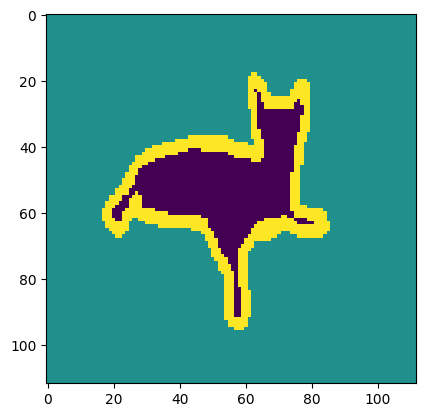

In [ ]:
plt.imshow(y[0])

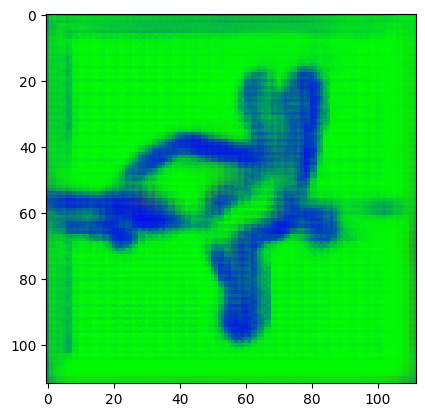

In [ ]:
plt.imshow(y_pred[0])

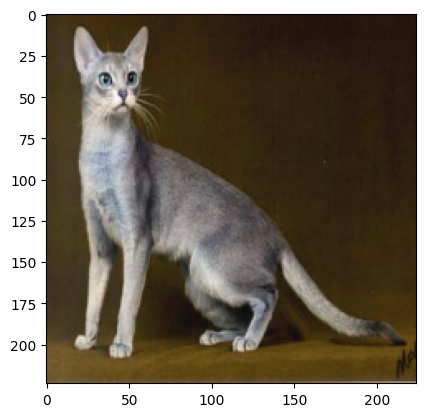

In [ ]:
test_img = cv2.imread("C:/Prajesh/personal/ML_learning/my_work/image_segmentation/dataset/oxford-iiit-pet/images/Abyssinian_67.jpg")
test_img = cv2.resize(test_img,(INPUT_DIM, INPUT_DIM))
plt.imshow(test_img)
test_img = np.expand_dims(test_img, axis = 0)

In [ ]:
p1 = seg_model.predict(test_img)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 2s 2s/step


In [ ]:
p1.shape

(1, 112, 112, 3)

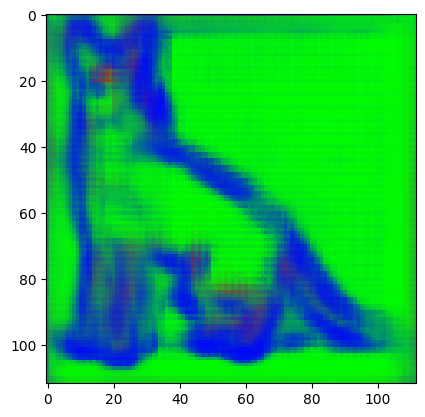

In [ ]:
plt.imshow(p1[0])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 0s 28ms/step


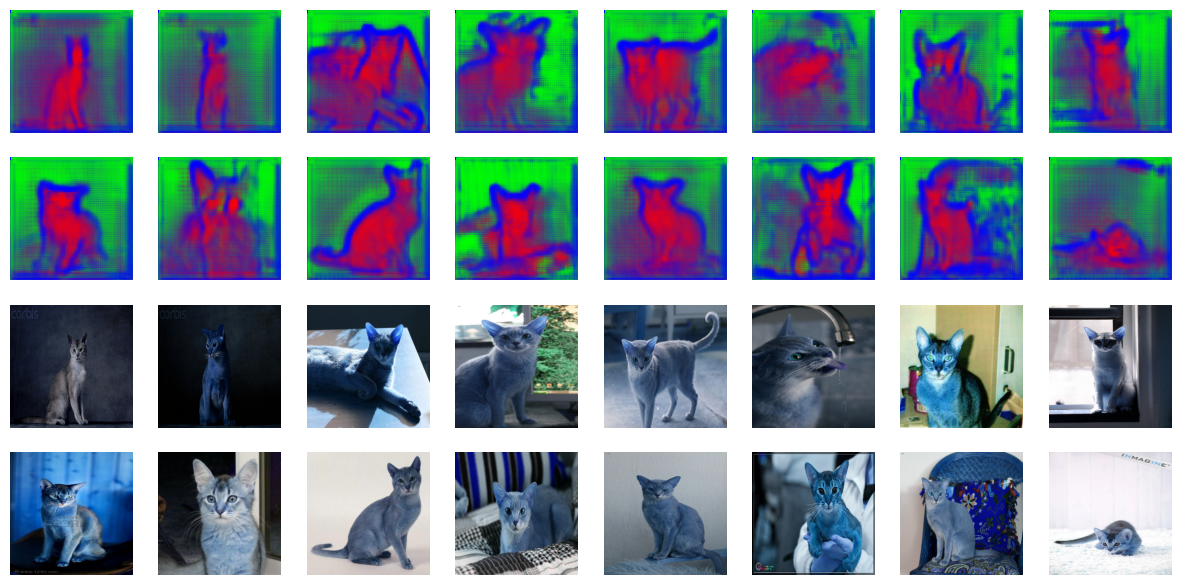

In [32]:
plt.figure(figsize = (15, 15))

for i in range(16, 32):
    plt.subplot(8, 8, i+1)
    img = cv2.imread(images_dir + os.listdir(images_dir)[i])
    img = cv2.resize(img,(INPUT_DIM, INPUT_DIM))
    img = np.expand_dims(img, axis = 0)
    plt.imshow((seg_model.predict(img))[0])
    plt.axis("off")
for i in range(32, 48):
    plt.subplot(8, 8, i+1)
    img = cv2.imread(images_dir + os.listdir(images_dir)[i-16])
    img = cv2.resize(img,(INPUT_DIM, INPUT_DIM))
    # img = np.expand_dims(img, axis = 0)
    plt.imshow(img)
    plt.axis("off")